# 0.0 Information
This code attempts to solve the challenge hosted on DrivenData.org
The challenge can be accessed via https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table

# 1.0 Problem Description
The challenge is to create a model that will predict the condition of a particular water pump ("waterpoint") given its many attributes

In [1]:
# general package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 2.0 Data: Data Preprocessing and Exploratory Data Analysis (EDA)
The datasets describe over 74,000 data points which represent a waterpoint in the Taarifa data catalog.

59,400 data points (80% of the entire dataset) are in the training group, while 14,850 data points (20%) are in the testing group.

The training data points have 40 features, one feature being the label for its current functionality. All data points have one feature that is the ID of the water point.

(for a great explanation about EDA, see https://towardsdatascience.com/exploratory-data-analysis-in-python-c9a77dfa39ce)

In [2]:
# import data
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
test_values = pd.read_csv('test_values.csv')

# print dataframe informations
dfs = (train_values,train_labels,test_values)
df_names = ('train_values','train_labels','test_values')

for i in range(len(dfs)):
    print('%s is a dataset of %d data points of %d features'%(df_names[i],dfs[i].shape[0],dfs[i].shape[1]))

train_values is a dataset of 59400 data points of 40 features
train_labels is a dataset of 59400 data points of 2 features
test_values is a dataset of 14850 data points of 40 features


## 2.1 Output categories

In [3]:
labels = train_labels.status_group.unique()
print('there are %d labels: \n'%len(labels))
labels_count = train_labels.status_group.value_counts()
print(labels_count)
labels_percentage = labels_count/np.sum(labels_count)*100
print('\neach with %.1f%%, %.1f%%, %.1f%%'%(labels_percentage[0],labels_percentage[1],labels_percentage[2]))

there are 3 labels: 

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

each with 54.3%, 38.4%, 7.3%


The output seems to be slightly imbalanced, but we're not sure if the imbalance is significant (for now). We'll come back to this later

## 2.2 Combine data
In order to efficiently preprocess data, and to apply the preprocessing measures to all datapoints, we combine the training and testing datasets

In [4]:
# 'status_group' column is assigned the status of each waterpoint, 'test' if unknown (i.e. the waterpoint belongs to the test dataset)
train_values['status_group']=train_labels.status_group
test_values['status_group']=['test']*test_values.shape[0]

# 'train' column discerns if the waterpoint belongs to the training group or the testing group
train_values['train']=[True]*train_values.shape[0]
test_values['train']=[False]*test_values.shape[0]

df = pd.concat([train_values,test_values])
print('df is a dataset of %d data points of %d features'%(df.shape[0],df.shape[1]))

df is a dataset of 74250 data points of 42 features


In [5]:
pd.set_option('display.max_columns', 8)

In [6]:
df.head()

,id,amount_tsh,date_recorded,funder,...,waterpoint_type,waterpoint_type_group,status_group,train
0,69572,6000.0,2011-03-14,Roman,...,communal standpipe,communal standpipe,functional,True
1,8776,0.0,2013-03-06,Grumeti,...,communal standpipe,communal standpipe,functional,True
2,34310,25.0,2013-02-25,Lottery Club,...,communal standpipe multiple,communal standpipe,functional,True
3,67743,0.0,2013-01-28,Unicef,...,communal standpipe multiple,communal standpipe,non functional,True
4,19728,0.0,2011-07-13,Action In A,...,communal standpipe,communal standpipe,functional,True


In [7]:
df.tail()

,id,amount_tsh,date_recorded,funder,...,waterpoint_type,waterpoint_type_group,status_group,train
14845,39307,0.0,2011-02-24,Danida,...,communal standpipe,communal standpipe,test,False
14846,18990,1000.0,2011-03-21,Hiap,...,hand pump,hand pump,test,False
14847,28749,0.0,2013-03-04,NaN,...,communal standpipe,communal standpipe,test,False
14848,33492,0.0,2013-02-18,Germany,...,communal standpipe,communal standpipe,test,False
14849,68707,0.0,2013-02-13,Government Of Tanzania,...,communal standpipe,communal standpipe,test,False


## 2.3 Drop features with too many N/A, NaN, null datapoints

In [8]:
# show the number of N/A, NaN, null datapoints per column
nulls = df.isnull().sum()
nulls

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [9]:
nulls_percentage = nulls[nulls!=0]/df.shape[0]*100
print('the percentages of null values per feature:\n')
print(round(nulls_percentage,2))

the percentages of null values per feature:

funder                6.07
installer             6.10
subvillage            0.63
public_meeting        5.60
scheme_management     6.53
scheme_name          47.49
permit                5.11
dtype: float64


it seems like the features that have null datapoints have significant number of datapoints. Hence, it is safe to eliminate entire features if they contain any null datapoints

In [10]:
features_original = df.shape[1]
df.dropna(axis='columns',how='any',inplace=True)
features_reduced = df.shape[1]
print('number of features reduced from %d to %d'%(features_original,features_reduced))

number of features reduced from 42 to 35


## 2.4 Identify numerical but categorical features
A dirty way to identify categorical features is to check if its values are non-numerical. But there are some features whose categories are numerical. This would mean that the magnitude of the numerical value has no innate meaning, i.e. the feature is categorical rather than ordinal.

A lot of times, we can't be sure whether or not a numerical feature is ordinal or categorical. We'd have to ask the people who actually assigned the number to the datapoint to see if they have innate meaning.

But by looking at how many "unique" numbers come up per feature, we can guess whether or not a numerical feature may be categorical.

In [11]:
df.select_dtypes(include='number').nunique()

id                   74250
amount_tsh             102
gps_height            2456
longitude            71870
latitude             71869
num_private             68
region_code             27
district_code           20
population            1128
construction_year       55
dtype: int64

Here, we can see that there are five features that have an abnormally low number of unique values. That is indicative that those numerical values actually stand for categorical values.

Looking at the dataset documentation, we find that three of the five features: 'num_private', 'region_code', 'district_code' are geographic codes whose numerical values probably don't have much meaning. Let's convert these into strings so that we can play with them in the next sections.

In [12]:
df['num_private'] = df.num_private.astype(str)
df['region_code'] = df.region_code.astype(str)
df['district_code'] = df.district_code.astype(str)

## 2.5 Drop categorical features with too many categories
Categorical features that have too many categories are usually not useful for predictive models. Let's find how many categories each categorical features have.

In [13]:
uniques = df.select_dtypes(exclude='number').nunique()
uniques

date_recorded              369
wpt_name                 45684
num_private                 68
basin                        9
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2098
recorded_by                  1
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 4
train                        2
dtype: int64

We have a few features whose number of categories do not justify them to be a "categorical" variable. Given that we have over 74,000 data points, a feature that has more than 740 categories will only less than 100 data points per category, in average. Let's remove features whose number of categories are over 740.

In [14]:
uniques[uniques>740]

wpt_name    45684
ward         2098
dtype: int64

In [15]:
features_original = df.shape[1]
df.drop(columns=['wpt_name','ward'],inplace=True)
features_reduced = df.shape[1]
print('number of features reduced from %d to %d'%(features_original,features_reduced))

number of features reduced from 35 to 33


## 2.6 Remove categorical features with too few values
We still have a lot of features left. We want to cut down on categorical features as they will blow up the number of features once we apply one-hot encoding.

Another type of categorical features that are usually useless are features that have categories that show up too infrequently. Let's find such features.

In the above section, we removed features whose "average" data points per category are less than 100 data points. Here, we'll remove features whose "minimum" data points per category are less than 100.

In [16]:
thresh = 100
features_original = df.shape[1]

for col in df.select_dtypes(exclude='number').columns:
    value_counts = df[col].value_counts()
    if value_counts.min(axis=0) < thresh:
        df.drop(columns=col,inplace=True)

features_reduced = df.shape[1]
print('number of features reduced from %d to %d'%(features_original,features_reduced))

number of features reduced from 33 to 23


Let's quickly check back to see which nonnumerical features have remained, and how many categories each have:

In [17]:
df.select_dtypes(exclude='number').nunique()

basin                     9
region                   21
recorded_by               1
extraction_type_group    13
extraction_type_class     7
management               12
management_group          5
payment                   7
payment_type              7
quality_group             6
quantity                  5
quantity_group            5
source_type               7
source_class              3
status_group              4
train                     2
dtype: int64

## 2.5 Drop irrelevant features

Okay let's quickly check which features we have left:

In [18]:
print('total number of features: %d\n'%(df.shape[1]))
df.dtypes

total number of features: 23



id                         int64
amount_tsh               float64
gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
population                 int64
recorded_by               object
construction_year          int64
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
quality_group             object
quantity                  object
quantity_group            object
source_type               object
source_class              object
status_group              object
train                       bool
dtype: object

To be honest, we can't quite be sure which features will be "irrelevant" when we haven't run any models (and seen their results) yet. This is especially true when combination of features, not individual features, may be the key to finding the right categorization scheme.

Let's see if there are "completely uncorrelated" features that, when deleted, might not affect the other features. This still doesn't gurantee that the feature is useless when combined with other features, but could direct us to a few hopefuls.

As in, let's draw some correlation heatmaps!

Note that we can draw correlation heatmaps only to numerical features for now. There is a way to draw correlation heatmaps for categorical variables but it's a lot dirtier.

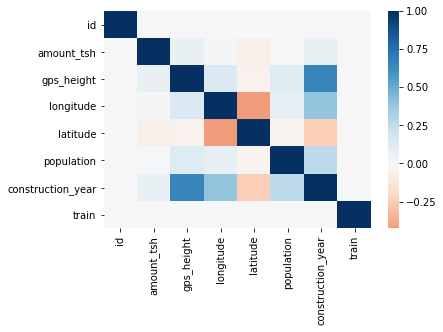

In [19]:
import seaborn as sns

sns.heatmap(df.corr(), cmap='RdBu',center=0)
plt.show()

There seems to be a few features that may hold no value in relation to other features. Let's sort the features to see deeper.

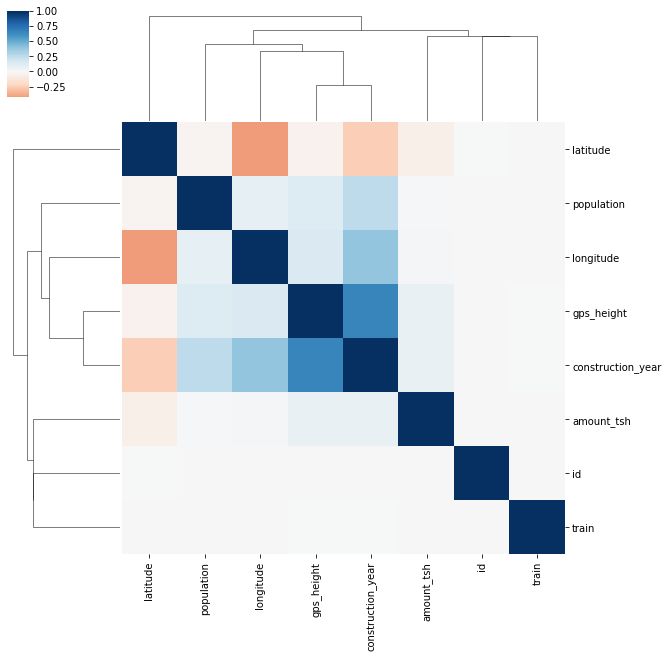

In [20]:
sns.clustermap(df.corr(), cmap='RdBu',center=0)

So the features 'amount_tsh' and 'id' seems to be relatively uncorrelated with the other features, and may be safely disregarded. To note, 'amount_tsh' is the 'amount of water available to waterpoint' and 'id' is, you know, the ID of the waterpoint. Neither seems particularily valuable so let's get rid of them.

Looking at the number of categories, we also see that the feature 'recorded_by' is a categorical feature with only ONE category. That's bound to be useless, so we can get rid of that too.

Also recognize that the feature 'train' is there for us to just keep of track of dataset groupings, so we don't have to care about that.

In [21]:
features_original = df.shape[1]
df.drop(columns = ['amount_tsh','id','recorded_by'],inplace=True)
features_reduced = df.shape[1]
print('number of features reduced from %d to %d'%(features_original,features_reduced))

number of features reduced from 23 to 20


## 2.6 One-hot encoding
Now that we think all the features left are "valuable" ones, we can go ahead and one-hot encode it! Remember this will blow up the total number of features of the dataset.

In [22]:
# these are the categorical features that we'll one-hot encode. Remember that we won't be one-hot encoding the 'status_group' and 'train' features as they're for our own use, and not used when training the models
columns_categorical = ['basin','region','extraction_type_group','extraction_type_class','management','management_group','payment','payment_type','quality_group','quantity','quantity_group','source_type','source_class']

features_original = df.shape[1]
df = pd.get_dummies(df,columns=columns_categorical)
features_reduced = df.shape[1]
print('number of features increased from %d to %d'%(features_original,features_reduced))

number of features increased from 20 to 114


## 2.7 Ordinality formatting
One last thing to do is to provide ordinality to the 'status_group' feature. While this is a categorical feature, it has ordinance. I.e., there's a ordinal relationship of fuctional > functional needs repair > non functional. A quick and dirty way to do this is by substituting the string values with numerical values.

Pandas does support an in-house ordering feature for Category type series, but it does get a bit hairy, so we'll not do that here. But to be strict, using  the ordinance method given by Pandas is more accurate, especially when the "distance" between the categories may not be equal. As in, by giving the numbers, we're saying that the magnitude of difference between 'functional' and 'functional needs repair' is the same as that of 'functional needs repair' and 'non functional'.

In [23]:
status_group_dict = {'functional':2,'functional needs repair':1,'non functional':0}
df.status_group = df.status_group.replace(status_group_dict)

That's it! Now we have a beautifully formatted dataset that we can now put into some models to churn out some predictions. We'll look at some models in the next section